#EDIMS Model

## Initialization

In [2]:
# put all installation here
! pip install mltu==0.1.3

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 45.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf2onnx to determine which ve

In [16]:
# put all import here

import os
import tensorflow as tf
import numpy as np
# Text Detection
from imutils.object_detection import non_max_suppression
import time
import cv2
import shutil

# Text Recognition
import typing

from tensorflow import keras
from keras import layers
from keras.models import Model
from mltu.model_utils import residual_block
from datetime import datetime
from mltu.configs import BaseModelConfigs
from tqdm import tqdm
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.dataProvider import DataProvider
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.losses import CTCloss
from mltu.callbacks import Model2onnx, TrainLogger
from mltu.metrics import CWERMetric
import json
from itertools import groupby

In [11]:
# Pre-trained model
! gdown 1U-okFPdqJFLkjnktSXfs77p9q2BZo8oE 
! gdown 1whxyj1_yS_0mZjSdNRuAr3aw-tqHWvcK

Downloading...
From: https://drive.google.com/uc?id=1U-okFPdqJFLkjnktSXfs77p9q2BZo8oE
To: /content/frozen_east_text_detection.pb
100% 96.7M/96.7M [00:01<00:00, 90.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VH_elD6kiNWAXe3abTztUDiPIz3om2ZI
To: /content/model.h5
100% 3.39M/3.39M [00:00<00:00, 71.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1whxyj1_yS_0mZjSdNRuAr3aw-tqHWvcK
To: /content/model.onnx
100% 1.02M/1.02M [00:00<00:00, 33.6MB/s]


In [5]:
# Date Dataset
! gdown 1bA3Wk9HmabxXPUADK4nbeVqUCjTVaAqh
! gdown 1PEChAstAXvXBSYEbbpuquR7Q7Wei8i-p

Downloading...
From: https://drive.google.com/uc?id=1bA3Wk9HmabxXPUADK4nbeVqUCjTVaAqh
To: /content/Date-Real.zip
100% 2.39M/2.39M [00:00<00:00, 29.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PEChAstAXvXBSYEbbpuquR7Q7Wei8i-p
To: /content/Date-Synth.zip
100% 392M/392M [00:10<00:00, 37.8MB/s]


In [6]:
! unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Date-Synth/images/95002.jpg  
  inflating: Date-Synth/images/95003.jpg  
  inflating: Date-Synth/images/95004.jpg  
  inflating: Date-Synth/images/95005.jpg  
  inflating: Date-Synth/images/95006.jpg  
  inflating: Date-Synth/images/95007.jpg  
  inflating: Date-Synth/images/95008.jpg  
  inflating: Date-Synth/images/95009.jpg  
  inflating: Date-Synth/images/95010.jpg  
  inflating: Date-Synth/images/95011.jpg  
  inflating: Date-Synth/images/95012.jpg  
  inflating: Date-Synth/images/95013.jpg  
  inflating: Date-Synth/images/95014.jpg  
  inflating: Date-Synth/images/95015.jpg  
  inflating: Date-Synth/images/95016.jpg  
  inflating: Date-Synth/images/95017.jpg  
  inflating: Date-Synth/images/95018.jpg  
  inflating: Date-Synth/images/95019.jpg  
  inflating: Date-Synth/images/95020.jpg  
  inflating: Date-Synth/images/95021.jpg  
  inflating: Date-Synth/images/95022.jpg  
  inflating: Date-Synth/images/95023.jpg  
  i

# Text Detection

## Preprocessing

In [2]:
# define crop object
class Crop(object):
    def __init__(self, startX, startY, endX, endY):
        self.startX = startX
        self.startY = startY
        self.endX = endX
        self.endY = endY

    def __eq__(self, other):
        diff = abs(self.startY - other.startY)
        if (diff <= 10):
            return self.startX == other.startX
        else:
            False

    def __lt__(self, other):
        diff = abs(self.startY - other.startY)
        if (diff <= 10):
            return self.startX < other.startX
        else:
            return self.startY < other.startY

In [19]:
# load the input image and grab the image dimensions
file_name = "./Products-Real/train/images/img_00004.jpg"
image = cv2.imread(file_name)
orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (1280, 1280)
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

## Modeling

In [20]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# load the pre-trained EAST text detector
net = cv2.dnn.readNet("model.pb")

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)

## Training

In [21]:
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

## Predicting

In [22]:
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

count = 1
# change box width and height -> positive will add pixels and vice-versa
box_width_padding = 3
box_height_padding = 3

temp_image = orig.copy()

# delete output folder
try:
    shutil.rmtree('output')
except Exception as e:
    do = "nothing"

# create empty output folder
uncreated = 1
while (uncreated):
    try:
        os.mkdir('output')
        uncreated = 0
    except Exception as e:
        do = "nothing"

croppedList = []

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW) - box_width_padding
    startY = int(startY * rH) - box_height_padding
    endX = int(endX * rW) + box_width_padding
    endY = int(endY * rH) + box_height_padding

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # append to croppedList to sort the images
    croppedList.append(Crop(startX, startY, endX, endY))

croppedList = sorted(croppedList)

for img in croppedList:
    roi = temp_image[img.startY:img.endY, img.startX:img.endX]
    cv2.imwrite("output/" + str(count) + ".jpg", roi)
    count = count + 1

# show the output image
cv2.imwrite("output/Text Detection.jpg", orig)
cv2.waitKey(0)

[INFO] text detection took 5.110027 seconds


-1

## Deployment

# Text Recognition

In [3]:
class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("./Models/1_image_to_word", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ "
        self.height = 32
        self.width = 128
        self.max_text_length = 23
        self.batch_size = 64
        self.learning_rate = 1e-4
        self.train_epochs = 15
        self.train_workers = 20

In [4]:
def ctc_decoder(predictions: np.ndarray, chars: typing.Union[str, list]) -> typing.List[str]:
    """ CTC greedy decoder for predictions

    Args:
        predictions (np.ndarray): predictions from model
        chars (typing.Union[str, list]): list of characters

    Returns:
        typing.List[str]: list of words
    """
    # use argmax to find the index of the highest probability
    argmax_preds = np.argmax(predictions, axis=-1)

    # use groupby to find continuous same indexes
    grouped_preds = [[k for k,_ in groupby(preds)] for preds in argmax_preds]

    # convert indexes to chars
    texts = ["".join([chars[k] for k in group if k < len(chars)]) for group in grouped_preds]

    return texts

def edit_distance(prediction_tokens: typing.List[str], reference_tokens: typing.List[str]) -> int:
    """ Standard dynamic programming algorithm to compute the Levenshtein Edit Distance Algorithm

    Args:
        prediction_tokens: A tokenized predicted sentence
        reference_tokens: A tokenized reference sentence
    Returns:
        Edit distance between the predicted sentence and the reference sentence
    """
    # Initialize a matrix to store the edit distances
    dp = [[0] * (len(reference_tokens) + 1) for _ in range(len(prediction_tokens) + 1)]

    # Fill the first row and column with the number of insertions needed
    for i in range(len(prediction_tokens) + 1):
        dp[i][0] = i

    for j in range(len(reference_tokens) + 1):
        dp[0][j] = j

    # Iterate through the prediction and reference tokens
    for i, p_tok in enumerate(prediction_tokens):
        for j, r_tok in enumerate(reference_tokens):
            # If the tokens are the same, the edit distance is the same as the previous entry
            if p_tok == r_tok:
                dp[i+1][j+1] = dp[i][j]
            # If the tokens are different, the edit distance is the minimum of the previous entries plus 1
            else:
                dp[i+1][j+1] = min(dp[i][j+1], dp[i+1][j], dp[i][j]) + 1

    # Return the final entry in the matrix as the edit distance
    return dp[-1][-1]

def get_cer(
    preds: typing.Union[str, typing.List[str]],
    target: typing.Union[str, typing.List[str]],
    ) -> float:
    """ Update the cer score with the current set of references and predictions.

    Args:
        preds (typing.Union[str, typing.List[str]]): list of predicted sentences
        target (typing.Union[str, typing.List[str]]): list of target words

    Returns:
        Character error rate score
    """
    if isinstance(preds, str):
        preds = [preds]
    if isinstance(target, str):
        target = [target]

    total, errors = 0, 0
    for pred_tokens, tgt_tokens in zip(preds, target):
        errors += edit_distance(list(pred_tokens), list(tgt_tokens))
        total += len(tgt_tokens)

    if total == 0:
        return 0.0

    cer = errors / total

    return cer

## Preprocessing

In [5]:
configs = ModelConfigs()

date_path_synth = "Date-Synth"
annotation_date_synth = date_path_synth + "/annotations.json"
date_path_real = "Date-Real"
annotation_date_real = date_path_real + "/annotations.json"

# Read metadata file and parse it
def read_annotation_file(data_path, annotation_path):
    dataset, vocab, max_len = [], set(), 0
    with open(annotation_path) as f:
        data = json.load (f)
        for line in tqdm(data):
            image_path = data_path + "/images/" + line
            label = ''
            for num in data[line]['ann']:
              label += num['transcription'] + " "
            label = label.strip()
            dataset.append([image_path,label])
            vocab.update(list(label))
            max_len = max(max_len,len(label))
    return dataset, sorted(vocab), max_len

train_dataset, train_vocab, max_train_len = read_annotation_file(date_path_synth, annotation_date_synth)
val_dataset, val_vocab, max_val_len = read_annotation_file(date_path_real, annotation_date_real)

# Save vocab and maximum text length to configs
configs.vocab = "".join(train_vocab)
configs.max_text_length = max(max_train_len, max_val_len)

# If BaseModelConfigs doesn't have a save method, you might need to save the configurations manually.
# For example, you could write them to a file:
with open('configs.json', 'w') as f:
    json.dump({'vocab': configs.vocab, 'max_text_length': configs.max_text_length}, f)

100%|██████████| 510/510 [00:00<00:00, 509550.99it/s]


In [6]:
# Create training data provider
train_data_provider = DataProvider(
    dataset=train_dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader()],
    transformers=[
        ImageResizer(configs.width, configs.height),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab))
        ],
)

# Create validation data provider
val_data_provider = DataProvider(
    dataset=val_dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader()],
    transformers=[
        ImageResizer(configs.width, configs.height),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab))
        ],
)

2023-12-22 13:03:18,685 INFO mltu.dataProvider: Skipping Dataset validation...
2023-12-22 13:03:18,686 INFO mltu.dataProvider: Skipping Dataset validation...


## Modeling

In [7]:
def train_model(input_dim, output_dim, activation='leaky_relu', dropout=0.2):

    inputs = layers.Input(shape=input_dim, name="input")

    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 64, activation=activation, skip_conv=True, strides=1, dropout=dropout)
    x7 = residual_block(x6, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x7.shape[-3] * x7.shape[-2], x7.shape[-1]))(x7)

    blstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(squeezed)

    output = layers.Dense(output_dim + 1, activation='softmax', name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [9]:
# Define learning_rate
configs.learning_rate = 0.001
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[CWERMetric()],
    run_eagerly=False
)
model.summary(line_length=110)

Model: "model_1"
______________________________________________________________________________________________________________
 Layer (type)                       Output Shape            Param #      Connected to                         
 input (InputLayer)                 [(None, 32, 128, 3)]    0            []                                   
                                                                                                              
 lambda_1 (Lambda)                  (None, 32, 128, 3)      0            ['input[0][0]']                      
                                                                                                              
 conv2d_18 (Conv2D)                 (None, 32, 128, 16)     448          ['lambda_1[0][0]']                   
                                                                                                              
 batch_normalization_14 (BatchNorma  (None, 32, 128, 16)    64           ['conv2d_18[0][0]']   

In [10]:
# Create necessary directories
os.makedirs(configs.model_path, exist_ok=True)

# Define callbacks
earlystopper = EarlyStopping(monitor='val_CER', patience=10, verbose=1)
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor='val_CER', verbose=1, save_best_only=True, mode='min')
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f'{configs.model_path}/logs', update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_CER', factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode='auto')
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=configs.train_workers
)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 30.7225 - CER: 1.1778 - WER: 1.0000
Epoch 1: val_CER improved from inf to 0.73547, saving model to ./Models/1_image_to_word\202312221303\model.h5


2023-12-22 13:26:50,792 INFO root: Epoch 0; loss: 30.722475051879883; CER: 1.0069814920425415; WER: 1.0; val_loss: 19.26193618774414; val_CER: 0.7354723215103149; val_WER: 1.0


2000/2000 [==============================] - 1382s 688ms/step - loss: 30.7225 - CER: 1.1777 - WER: 1.0000 - val_loss: 19.2619 - val_CER: 0.7355 - val_WER: 1.0000 - lr: 0.0010
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 19.5174 - CER: 0.7515 - WER: 1.0000
Epoch 2: val_CER improved from 0.73547 to 0.64795, saving model to ./Models/1_image_to_word\202312221303\model.h5


2023-12-22 13:47:02,659 INFO root: Epoch 1; loss: 19.517431259155273; CER: 0.7283403277397156; WER: 1.0; val_loss: 16.252309799194336; val_CER: 0.6479501128196716; val_WER: 1.0


2000/2000 [==============================] - 1212s 606ms/step - loss: 19.5174 - CER: 0.7515 - WER: 1.0000 - val_loss: 16.2523 - val_CER: 0.6480 - val_WER: 1.0000 - lr: 0.0010
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 14.0226 - CER: 0.6445 - WER: 1.0000
Epoch 3: val_CER improved from 0.64795 to 0.26061, saving model to ./Models/1_image_to_word\202312221303\model.h5


2023-12-22 14:07:52,584 INFO root: Epoch 2; loss: 14.022631645202637; CER: 0.5734351277351379; WER: 0.9998593926429749; val_loss: 4.205854415893555; val_CER: 0.260606050491333; val_WER: 1.0


2000/2000 [==============================] - 1250s 625ms/step - loss: 14.0226 - CER: 0.6444 - WER: 1.0000 - val_loss: 4.2059 - val_CER: 0.2606 - val_WER: 1.0000 - lr: 0.0010
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 5.5283 - CER: 0.3745 - WER: 0.9921
Epoch 4: val_CER improved from 0.26061 to 0.16381, saving model to ./Models/1_image_to_word\202312221303\model.h5


2023-12-22 14:29:17,144 INFO root: Epoch 3; loss: 5.52825403213501; CER: 0.3385359048843384; WER: 0.9793359637260437; val_loss: 1.1281838417053223; val_CER: 0.16381461918354034; val_WER: 0.9784313440322876


2000/2000 [==============================] - 1285s 642ms/step - loss: 5.5283 - CER: 0.3745 - WER: 0.9921 - val_loss: 1.1282 - val_CER: 0.1638 - val_WER: 0.9784 - lr: 0.0010
Epoch 5/15
2000/2000 [==============================] - ETA: 0s - loss: 2.8322 - CER: 0.2670 - WER: 0.9270
Epoch 5: val_CER improved from 0.16381 to 0.15330, saving model to ./Models/1_image_to_word\202312221303\model.h5


2023-12-22 14:50:32,860 INFO root: Epoch 4; loss: 2.8322315216064453; CER: 0.25782904028892517; WER: 0.911734402179718; val_loss: 0.6328455209732056; val_CER: 0.15329767763614655; val_WER: 0.9686274528503418


2000/2000 [==============================] - 1276s 638ms/step - loss: 2.8322 - CER: 0.2670 - WER: 0.9270 - val_loss: 0.6328 - val_CER: 0.1533 - val_WER: 0.9686 - lr: 0.0010
Epoch 6/15
2000/2000 [==============================] - ETA: 0s - loss: 2.0492 - CER: 0.2382 - WER: 0.8777
Epoch 6: val_CER improved from 0.15330 to 0.14795, saving model to ./Models/1_image_to_word\202312221303\model.h5


2023-12-22 15:13:56,586 INFO root: Epoch 5; loss: 2.0492498874664307; CER: 0.23488925397396088; WER: 0.8694921731948853; val_loss: 0.5502409934997559; val_CER: 0.14795008301734924; val_WER: 0.95686274766922


2000/2000 [==============================] - 1404s 702ms/step - loss: 2.0492 - CER: 0.2382 - WER: 0.8777 - val_loss: 0.5502 - val_CER: 0.1480 - val_WER: 0.9569 - lr: 0.0010
Epoch 7/15
1620/2000 [=======================>......] - ETA: 4:35 - loss: 1.7027 - CER: 0.2261 - WER: 0.8518

KeyboardInterrupt: 

## Training

## Predicting

In [9]:
import cv2
import typing
import numpy as np

from mltu.inferenceModel import OnnxInferenceModel

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, self.input_shape[:2][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(None, {self.input_name: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

Image: Date-Synth/images/00003.jpg, Label: 08 09 2019, Prediction: R7RJlR0V, CER: 0.9


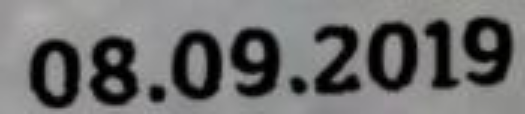

Average CER: 0.9


In [22]:
accum_cer = []
image_path, label = train_dataset[3]
image = cv2.imread(image_path)
model = ImageToWordModel(model_path="model.onnx", char_list=configs.vocab)

prediction_text = model.predict(image)

cer = get_cer(prediction_text, label)
print(f"Image: {image_path}, Label: {label}, Prediction: {prediction_text}, CER: {cer}")

# resize image by 3 times for visualization
image = cv2.resize(image, (image.shape[1] * 3, image.shape[0] * 3))
cv2.imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

accum_cer.append(cer)

print(f"Average CER: {np.average(accum_cer)}")